In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import PIL
import os
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
from sys import platform
from importlib import reload

# Local imports
import sys
sys.path.append('../')
import stlstuff as sls
import imagestuff as ims; reload(ims)
import statstuff as sts

In [2]:
%matplotlib notebook

In [3]:
# Have to do this in case of different operating systems
if platform == "linux" or platform == "darwin":
    slash = '/'
else: # This is assumed to be Windows
    slash = '\\'
#print(slash)

In [4]:
# Graphics parameters
fontsize = 10
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

In [34]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd(); startpos = len(pwd)-pwd[::-1].find(slash)
case = pwd[startpos:]; print(case)
Segmentroot='Segments2'; print(Segmentroot)

Examplecase
Segments2


In [52]:
# Derivative names
Compressedfilename = Segmentroot+'retrieved.npz'; print (Compressedfilename)
Flattenedfilename = Segmentroot+'flattened.npz'; print(Flattenedfilename)

Segments2retrieved.npz
Segments2flattened.npz


In [36]:
# Get the retrieved surface
npzfile = np.load(Compressedfilename)
imageroot = np.array_str(npzfile['imageroot'])
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("dx and dy", dx, dy)

dx and dy 0.5669643 0.5669643


In [37]:
nx1list = npzfile['nx1list']
nx2list = npzfile['nx2list']
ny1list = npzfile['ny1list']
ny2list = npzfile['ny2list']
solution = npzfile['solution']
nsegments = len(nx1list)

<IPython.core.display.Javascript object>


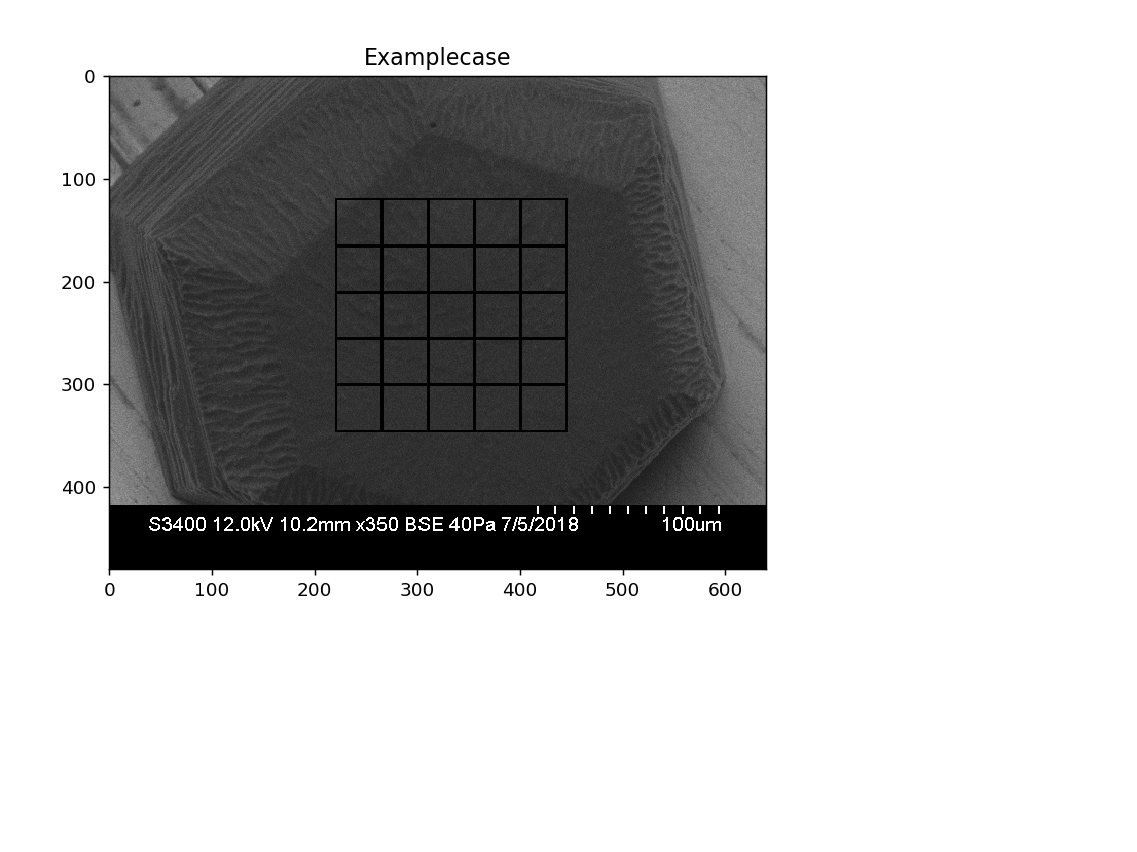

Text(0.5,1,'Examplecase')

In [62]:
# Graph the segments
im = PIL.Image.open(Filename)
ny_im,nx_im = np.shape(im)
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)
plt.imshow(np.asarray(im),cmap = 'Greys_r', vmin = 0,vmax = 255)
plt.title(case)

In [38]:
# Do the extraction
xseggrid, yseggrid, zseggrid = ims.extractflat(npzfile,dx,dy)

In [58]:
# Save the flattened segments
np.savez_compressed(Flattenedfilename, \
                    xseggrid=xseggrid, \
                    yseggrid=yseggrid, \
                    zseggrid=zseggrid)